In [1]:
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler
import torch
from torch.nn import MultiheadAttention
from torch import optim
import torch.nn as nn

device = "cuda:2"

model = TabPFNClassifier(device=device)
module = model.model[2]

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:2 device
Batch size: 1
Using distributed training: False
Using a Transformer with 25.82 M parameters


In [2]:
from tabpfn.utils import normalize_data, to_ranking_low_mem, remove_outliers
from tabpfn.priors.utils import normalize_by_used_features_f

normalize_with_test = True #TODO change
#eval_position = 100
normalize_to_ranking = False
max_features=100
normalize_with_sqrt = False

def preprocess_input(eval_xs, eval_ys, categorical_feats, preprocess_transform):
    import warnings

    if eval_xs.shape[1] > 1:
        raise Exception("Transforms only allow one batch dim - TODO")
    if preprocess_transform != 'none':
        if preprocess_transform == 'power' or preprocess_transform == 'power_all':
            pt = PowerTransformer(standardize=True)
        elif preprocess_transform == 'quantile' or preprocess_transform == 'quantile_all':
            pt = QuantileTransformer(output_distribution='normal')
        elif preprocess_transform == 'robust' or preprocess_transform == 'robust_all':
            pt = RobustScaler(unit_variance=True)

    # eval_xs, eval_ys = normalize_data(eval_xs), normalize_data(eval_ys)
    eval_xs = normalize_data(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position)

    # Removing empty features
    eval_xs = eval_xs[:, 0, :]
    sel = [len(torch.unique(eval_xs[0:eval_ys.shape[0], col])) > 1 for col in range(eval_xs.shape[1])]
    eval_xs = eval_xs[:, sel]

    warnings.simplefilter('error')
    if preprocess_transform != 'none':
        eval_xs = eval_xs.cpu().numpy()
        feats = set(range(eval_xs.shape[1])) if 'all' in preprocess_transform else set(
            range(eval_xs.shape[1])) - set(categorical_feats)
        for col in feats:
            try:
                pt.fit(eval_xs[0:eval_position, col:col + 1])
                trans = pt.transform(eval_xs[:, col:col + 1])
                # print(scipy.stats.spearmanr(trans[~np.isnan(eval_xs[:, col:col+1])], eval_xs[:, col:col+1][~np.isnan(eval_xs[:, col:col+1])]))
                eval_xs[:, col:col + 1] = trans
            except:
                pass
        eval_xs = torch.tensor(eval_xs).float()
    warnings.simplefilter('default')

    eval_xs = eval_xs.unsqueeze(1)

    # TODO: Cautian there is information leakage when to_ranking is used, we should not use it
    eval_xs = remove_outliers(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position) if not normalize_to_ranking else normalize_data(to_ranking_low_mem(eval_xs))
    # Rescale X
    eval_xs = normalize_by_used_features_f(eval_xs, eval_xs.shape[-1], max_features,
                                            normalize_with_sqrt=normalize_with_sqrt)

    return eval_xs.detach().to(device)


In [3]:
def compute_accuracy_rf(X, y, n_train):
    # Move X and y to CPU
    X = X.to("cpu")
    y = y.to("cpu")
    # check if regression or classification
    if len(np.unique(y)) > len(y) / 3:
        rf = RandomForestRegressor()
        classif = False
        print("Regression")
    else:
        rf = RandomForestClassifier()
        classif = True
        print("Classification")
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    if classif:
        return accuracy_score(y_test, y_pred)
    else:
        # mean absolute error
        return mean_squared_error(y_test, y_pred)

def compute_accuracy_tabpfn_original(X, y, n_train):
    X = X.to("cpu") #FIXME
    y = y.to("cpu")
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def compute_accuracy_tabpfn(X, y, n_train, preprocess=False):
    # reshape X to be 3D
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # reshape y to be 2D
    y = y.reshape(y.shape[0], 1)
    if preprocess:
        X = preprocess_input(X, y, [], 'power')
    X = X.to(device)
    y_pred = torch.argmax(module((X, y), single_eval_pos=n_train, x_already_encoded=False), dim=-1).reshape(-1)
    # Check the accuracy
    print(accuracy_score(y[-len(y_pred):].cpu(), y_pred.cpu())) #FIXME
    

In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F

# class PairwiseTransformer(nn.Module):
#     def __init__(self, n_features, n_features_2, nhead, dim_feedforward):
#         super(PairwiseTransformer, self).__init__()
#         self.transformer = nn.Transformer(
#             d_model=n_features + n_features_2,
#             nhead=nhead,
#             num_encoder_layers=1,
#             num_decoder_layers=1,
#             dim_feedforward=dim_feedforward,
#         )
#         self.fc = nn.Linear(n_features + n_features_2, 1)

#     def forward(self, x1, x2):
#         print(x1.shape)
#         print(x2.shape)
#         combined_input = torch.cat((x1, x2), dim=-1).unsqueeze(0)
#         print(combined_input.shape)
#         output = self.transformer(combined_input, combined_input)
#         output = output.squeeze(0)
#         score = self.fc(output)
#         return score.squeeze(-1)

import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, classif=True):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.classif = classif
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        if self.classif:
            out = F.softmax(out, dim=-1)
        return out

class PairwiseMLP(nn.Module):
    def __init__(self, n_features, n_features_2, dim_feedforward):
        super(PairwiseMLP, self).__init__()
        self.fc1 = nn.Linear(n_features + n_features_2, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, dim_feedforward)
        self.fc3 = nn.Linear(dim_feedforward, 1)

    def forward(self, x1, x2):
        combined_input = torch.cat((x1, x2), dim=-1)
        output = F.relu(self.fc1(combined_input))
        output = F.relu(self.fc2(output))
        score = self.fc3(output)
        return score.squeeze(-1)
    

class CustomModel(nn.Module):
    def __init__(self, n_features, n_features_2, dim_feedforward):
        super(CustomModel, self).__init__()
        self.scorer = PairwiseMLP(n_features, n_features_2, dim_feedforward)

    def forward(self, M1, M2):
        scores = []
        for i in range(M1.size(0)):
                score = self.scorer(M1[i].repeat(M2.shape[0], 1), M2)
                scores.append(score)
        scores = torch.stack(scores).view(M1.size(0), M2.size(0))
        # Normalize scores
        scores = F.softmax(scores, dim=1)
        M2_avg = scores @ M2
        return torch.cat((M1, M2_avg), dim=1)

# Example usage
n_samples_batch, n_features = 32, 128
n_samples_2, n_features_2 = 16, 64
nhead = 8
dim_feedforward = 256

matching_model = CustomModel(n_features, n_features_2, dim_feedforward)

M1 = torch.randn(n_samples_batch, n_features)
M2 = torch.randn(n_samples_2, n_features_2)

output = matching_model(M1, M2)
print(output.shape)  # Expected output shape: (n_samples_batch, n_features + n_features_2)

    


torch.Size([32, 192])


In [23]:
def train_matching(X1, X2, y, batch_size, scorer, preprocess=False, lr=0.01, n_epochs=100, dim_feedforward=256, train_prop=0.7, n_train=None, ):
    # reshape X to be 3D
    X1 = X1.reshape(X1.shape[0], 1, X1.shape[1])
    X2 = X2.reshape(X2.shape[0], 1, X2.shape[1])
    # reshape y to be 2D
    y = y.reshape(y.shape[0], 1)
    # check if classification or regression
    if len(torch.unique(y)) > len(y) / 3:
        classif = False
        print("regression")
    else:
        classif = True
        print("classification")
    if preprocess:
        X1 = preprocess_input(X1, y, [], 'power')
        X2 = preprocess_input(X2, y, [], 'power')
    # reshape X to be 2D
    X1 = X1.reshape(X1.shape[0], X1.shape[2])
    X2 = X2.reshape(X2.shape[0], X2.shape[2]).to(device)
    # reshape y to be 1D
    y = y.reshape(y.shape[0])
    if classif:
        n_classes = torch.unique(y).shape[0]
        print("num classes", n_classes)
        predictor = MLP(input_size=X1.shape[1] + X2.shape[1], hidden_size=dim_feedforward, output_size=n_classes, classif=True)
    else:
        predictor = MLP(input_size=X1.shape[1] + X2.shape[1], hidden_size=dim_feedforward, output_size=1, classif=False)

    # move to GPU
    scorer = scorer.to(device)
    predictor = predictor.to(device)
    optimizer = optim.Adam([*scorer.parameters(), *predictor.parameters()], lr=lr)
    # create a dataset
    print(X1.shape)
    print(y.shape)
    assert train_prop is not None or n_train is not None
    assert train_prop is None or n_train is None
    if n_train is not None:
        X1_train = X1[:n_train]
        y_train = y[:n_train]
        X1_test = X1[n_train:]
        y_test = y[n_train:]
    else:
        X1_train = X1[:int(train_prop * len(X1))]
        X1_test = X1[int(train_prop * len(X1)):]
        y_train = y[:int(train_prop * len(y))]
        y_test = y[int(train_prop * len(y)):]
    dataset_train = torch.utils.data.TensorDataset(X1_train, y_train)
    dataset_test = torch.utils.data.TensorDataset(X1_test, y_test)
    # create a data loader
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    if classif:
        loss_function = torch.nn.CrossEntropyLoss()
    else:
        loss_function = torch.nn.MSELoss()
    for epoch in range(n_epochs):
        train_loss = 0
        train_score = 0
        for X1_batch, y_batch in dataloader_train:
            # move to GPU
            X1_batch = X1_batch.to(device)
            y_batch = y_batch.to(device)
            # get the predictions
            output = scorer(X1_batch, X2)
            output = predictor(output).reshape(-1)
            # calculate the loss
            loss = loss_function(output, y_batch)
            train_loss += loss.data.item()
            if classif:
                score = (output.argmax(dim=1) == y_batch).float().mean()
            else:
                score = mean_squared_error(output.detach().cpu(), y_batch.cpu())
            train_score += score
            #print("Train loss", loss.item())
            # backprop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 10 == 0:
            print("Epoch", epoch)
            print("----------------")
            print("Train loss", train_loss / len(dataloader_train))
            print("Train score", train_score / len(dataloader_train))
            # calculate the accuracy
            print("---------------")
            test_loss = 0
            test_accuracy = 0
            for X1_batch, y_batch in dataloader_test:
                # move to GPU
                X1_batch = X1_batch.to(device)
                y_batch = y_batch.to(device)
                # Calculate the predictions
                output = scorer(X1_batch, X2)
                output = predictor(output).reshape(-1)
                # calculate the loss and accuracy
                loss = loss_function(output, y_batch)
                test_loss += loss.data.item()
                # calculate the accuracy
                if classif:
                    y_pred = output.argmax(dim=1)
                    score = (y_pred == y_batch).float().mean()
                else:
                    score = mean_squared_error(output.detach().cpu(), y_batch.cpu())
                test_accuracy += score
            print("Test loss", test_loss / len(dataloader_test))
            print("Test accuracy", test_accuracy / len(dataloader_test))
            print("---------------")
    return scorer, predictor, test_accuracy / len(dataloader_test)


def train_mlp(X1, y, batch_size, preprocess=False, lr=0.01, n_epochs=100, dim_feedforward=256, train_prop=0.7, n_train=None):
    # reshape X to be 3D
    X1 = X1.reshape(X1.shape[0], 1, X1.shape[1])
    # reshape y to be 2D
    y = y.reshape(y.shape[0], 1)
    # check if classification or regression
    if len(torch.unique(y)) > len(y) / 3:
        classif = False
        print("regression")
    else:
        classif = True
        print("classification")
    if preprocess:
        X1 = preprocess_input(X1, y, [], 'power')
    # reshape X to be 2D
    X1 = X1.reshape(X1.shape[0], X1.shape[2])
    # reshape y to be 1D
    y = y.reshape(y.shape[0])
    if classif:
        n_classes = torch.unique(y).shape[0]
        print("num classes", n_classes)
        predictor = MLP(input_size=X1.shape[1], hidden_size=dim_feedforward, output_size=n_classes, classif=True)
    else:
        predictor = MLP(input_size=X1.shape[1], hidden_size=dim_feedforward, output_size=1, classif=False)

    # move to GPU
    predictor = predictor.to(device)
    optimizer = optim.Adam([*predictor.parameters()], lr=lr)
    # create a dataset
    print(X1.shape)
    print(y.shape)
    assert train_prop is not None or n_train is not None
    assert train_prop is None or n_train is None
    if n_train is not None:
        X1_train = X1[:n_train]
        y_train = y[:n_train]
        X1_test = X1[n_train:]
        y_test = y[n_train:]
    else:
        X1_train = X1[:int(train_prop * len(X1))]
        X1_test = X1[int(train_prop * len(X1)):]
        y_train = y[:int(train_prop * len(y))]
        y_test = y[int(train_prop * len(y)):]
    dataset_train = torch.utils.data.TensorDataset(X1_train, y_train)
    dataset_test = torch.utils.data.TensorDataset(X1_test, y_test)
    # create a data loader
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    if classif:
        loss_function = torch.nn.CrossEntropyLoss()
    else:
        loss_function = torch.nn.MSELoss()
    for epoch in range(n_epochs):
        train_loss = 0
        train_score = 0
        for X1_batch, y_batch in dataloader_train:
            # move to GPU
            X1_batch = X1_batch.to(device)
            y_batch = y_batch.to(device)
            # get the predictions
            output = predictor(X1_batch).reshape(-1)
            # calculate the loss
            loss = loss_function(output, y_batch)
            train_loss += loss.data.item()
            if classif:
                score = (output.argmax(dim=1) == y_batch).float().mean()
            else:
                score = mean_squared_error(output.detach().cpu(), y_batch.cpu())
            train_score += score
            #print("Train loss", loss.item())
            # backprop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 10 == 0:
            print("Epoch", epoch)
            print("----------------")
            print("Train loss", train_loss / len(dataloader_train))
            print("Train score", train_score / len(dataloader_train))
            # calculate the accuracy
            print("---------------")
            test_loss = 0
            test_accuracy = 0
            for X1_batch, y_batch in dataloader_test:
                # move to GPU
                X1_batch = X1_batch.to(device)
                y_batch = y_batch.to(device)
                # Calculate the predictions
                output = predictor(X1_batch).reshape(-1)
                # calculate the loss and accuracy
                loss = loss_function(output, y_batch)
                test_loss += loss.data.item()
                # calculate the accuracy
                if classif:
                    y_pred = output.argmax(dim=1)
                    score = (y_pred == y_batch).float().mean()
                else:
                    score = mean_squared_error(output.detach().cpu(), y_batch.cpu())
                test_accuracy += score
            print("Test loss", test_loss / len(dataloader_test))
            print("Test accuracy", test_accuracy / len(dataloader_test))
            print("---------------")
    return predictor, test_accuracy / len(dataloader_test)

            
    

# Toy example

In [19]:
class MLPDeep(nn.Module):
    def __init__(self, n_layers, input_size, hidden_size, output_size, classif=True):
        super(MLPDeep, self).__init__()
        self.classif = classif
        # create the layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_size, output_size))
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        for layer in self.layers:
            out = layer(out)
        if self.classif:
            out = F.softmax(out, dim=-1)
        return out

In [20]:
X1 = torch.randn(500, 10)
X2 = torch.randn(3000, 10)

# Create a random function with an MLP
f = MLP(input_size=10, hidden_size=100, output_size=1, classif=False)
with torch.no_grad():
    y = f(X1)



In [21]:
print("-- Random Forest --")
#y = f(X2)
print("Accuracy with dataset1", compute_accuracy_rf(X1.detach(), y.detach(), 300))
#print("Accuracy with dataset2", compute_accuracy_rf(dataset2, y, 1000))
#print("Accuracy with dataset1 + dataset2", compute_accuracy_rf(torch.cat((dataset1, dataset2), dim=1), y, 1000))

-- Random Forest --
Regression


/tmp/ipykernel_31826/1262600036.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Accuracy with dataset1 0.012089291143772947


In [22]:
train_matching(X1, X2, y, 300, preprocess=True, lr=0.001, n_epochs=100)

regression


UnboundLocalError: local variable 'scorer' referenced before assignment

In [29]:
# create a pytorch module 
class OracleScorer(nn.Module):
    def __init__(self, n_features, n_features_2, dim_feedforward):
        super(OracleScorer, self).__init__()

    def forward(self, M1, M2):
        scores = []
        for i in range(M1.size(0)):
                score = torch.exp(-((M1[i].repeat(M2.shape[0], 1) -  M2[:, :-1])**2).sum(dim=1))
                scores.append(score)
        scores = torch.stack(scores).view(M1.size(0), M2.size(0))
        # Normalize scores
        scores = F.softmax(scores, dim=1)
        M2_avg = scores @ M2
        return torch.cat((M1, M2_avg), dim=1)

In [45]:
torch.mean(y_test)

tensor(0.0634)

In [61]:
from sklearn.model_selection import train_test_split
n_trials = 10
res_rf_X1 = np.zeros(n_trials)
res_mlp_X1 = np.zeros(n_trials)
res_rf_X1_large = np.zeros(n_trials)
res_mlp_X1_large = np.zeros(n_trials)
res_ours = np.zeros(n_trials)
res_test = np.zeros(n_trials)
res_ours_oracle = np.zeros(n_trials)
predict_mean = np.zeros(n_trials)
predict_mean_large = np.zeros(n_trials)
train_size_small = 300
train_size_large = 3500
for i in range(n_trials):
    print("Trial", i)
    print("---------------")
    X1 = torch.randn(3000, 10)
    X2 = torch.randn(3000, 11)
    X3 = torch.randn(6000, 10)
    # Create a random function with an MLP
    #f = MLPDeep(n_layers=3, input_size=10, hidden_size=256, output_size=1, classif=False)
    f = nn.Linear(10, 1)
    f = f.to(device)
    X1 = X1.to(device)
    X2 = X2.to(device)
    X3 = X3.to(device)
    with torch.no_grad():
        y = f(X1) + (torch.randn(X1.shape[0]).to(device) * 0.1).reshape(-1, 1)
        X2[:, 10] = (f(X2[:, :10]) + (torch.randn(X2.shape[0]).to(device) * 0.1).reshape(-1, 1)).reshape(-1)
        print("y", y.shape)
    #res_rf_X1[i] = compute_accuracy_rf(X1.detach(), y.detach(), train_size_small)
    rf = RandomForestRegressor()
    # split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X1.detach().cpu(), y.detach().cpu(), train_size=train_size_small)
    rf.fit(X_train, y_train)
    res_rf_X1[i] = mean_squared_error(rf.predict(X_test), y_test)

    # Find top 10 match in X2
    y_pred = np.zeros(X1.shape[0])
    for j in range(X1.shape[0]):
        X2 = X2.cpu()
        X1 = X1.cpu()
        y_pred[j] = torch.mean(X2[:, 10][np.argsort(np.linalg.norm(X2[:, :10] - X1[j], axis=1))[:10]])
    res_test[i] = mean_squared_error(y_pred, y.detach().cpu())


    predictor, test_score = train_mlp(X1, y, 256, lr=0.001, n_epochs=60, dim_feedforward=32, n_train=train_size_small, train_prop=None)
    res_mlp_X1[i] = test_score
    with torch.no_grad():
        y2 = f(X3) + (torch.randn(6000).to(device) * 0.1).reshape(-1, 1)
    
    rf = RandomForestRegressor()
    # split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X3.detach().cpu(), y2.detach().cpu(), train_size=train_size_large)
    rf.fit(X_train, y_train)
    res_rf_X1_large[i] = mean_squared_error(rf.predict(X_test), y_test)


    predictor, test_score = train_mlp(X3, y2, 256, lr=0.001, n_epochs=60, dim_feedforward=32, n_train=train_size_large, train_prop=None)
    res_mlp_X1_large[i] = test_score

    scorer = CustomModel(n_features=X1.shape[1], n_features_2=X2.shape[1], dim_feedforward=dim_feedforward)
    scorer, predictor, test_score = train_matching(X1, X2, y, 256, scorer, preprocess=True, lr=0.001, n_epochs=60, dim_feedforward=32, n_train=train_size_small, train_prop=None)
    res_ours[i] = test_score

    scorer = OracleScorer(n_features=X1.shape[1], n_features_2=X2.shape[1], dim_feedforward=dim_feedforward)
    scorer, predictor, test_score = train_matching(X1, X2, y, 256, scorer, preprocess=True, lr=0.001, n_epochs=60, dim_feedforward=32, n_train=train_size_small, train_prop=None)
    res_ours_oracle[i] = test_score

    # try to predict the mean
    X_train, X_test, y_train, y_test = train_test_split(X1.detach().cpu(), y.detach().cpu(), train_size=train_size_small)
    predict_mean[i] = mean_squared_error(torch.mean(y_train) * torch.ones(y_test.shape), y_test)

    X_train, X_test, y_train, y_test = train_test_split(X3.detach().cpu(), y2.detach().cpu(), train_size=train_size_large)
    print(torch.mean(y_train, dim=0) * torch.ones(y_test.shape))
    predict_mean_large[i] = mean_squared_error(torch.mean(y_train, dim=0) * torch.ones(y_test.shape), y_test)
    

    

    



Trial 0
---------------
y torch.Size([3000, 1])


/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.32000168412923813
Train score 0.32000168412923813
---------------
Test loss 0.36174731904810126
Test accuracy 0.3617473163387992
---------------
Epoch 10
----------------
Train loss 0.22820822149515152
Train score 0.22820819169282913
---------------
Test loss 0.22776450894095682
Test accuracy 0.22776450352235275
---------------
Epoch 20
----------------
Train loss 0.13859032094478607
Train score 0.13859032094478607
---------------
Test loss 0.1514539677988399
Test accuracy 0.15145396508953787
---------------
Epoch 30
----------------
Train loss 0.08367393165826797
Train score 0.08367393538355827
---------------
Test loss 0.0942290567538955
Test accuracy 0.09422905539924448
---------------
Epoch 40
----------------
Train loss 0.04970800690352917
Train score 0.04970800317823887
---------------
Test loss 0.05735083432360129
Test accuracy 0.057350835339589554
---------------
Epoch 50
----------------

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.3127557049904551
Train score 0.31275570179734913
---------------
Test loss 0.24722449183464051
Test accuracy 0.24722449183464051
---------------
Epoch 10
----------------
Train loss 0.01844677914466177
Train score 0.018446779011615684
---------------
Test loss 0.017500981129705905
Test accuracy 0.017500981595367192
---------------
Epoch 20
----------------
Train loss 0.012764798344245978
Train score 0.012764798144676856
---------------
Test loss 0.013009603321552276
Test accuracy 0.013009602949023247
---------------
Epoch 30
----------------
Train loss 0.01158083469739982
Train score 0.011580834564353739
---------------
Test loss 0.012042783107608557
Test accuracy 0.012042783107608557
---------------
Epoch 40
----------------
Train loss 0.01116582831101758
Train score 0.01116582824449454
---------------
Test loss 0.011796679627150298
Test accuracy 0.011796679627150298
---------------
Epoch 50
---

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.4145529419183731
Train score 0.4145529121160507
---------------
Test loss 0.44251002777706494
Test accuracy 0.4425100250677629
---------------
Epoch 10
----------------
Train loss 0.2856893837451935
Train score 0.2856893986463547
---------------
Test loss 0.28966177187182685
Test accuracy 0.28966177864508197
---------------
Epoch 20
----------------
Train loss 0.16761307418346405
Train score 0.16761308163404465
---------------
Test loss 0.17814076082272964
Test accuracy 0.1781407594680786
---------------
Epoch 30
----------------
Train loss 0.09728269279003143
Train score 0.09728268906474113
---------------
Test loss 0.10278561575846239
Test accuracy 0.10278561575846239
---------------
Epoch 40
----------------
Train loss 0.044847168028354645
Train score 0.044847166165709496
---------------
Test loss 0.056748503988439385
Test accuracy 0.05674850432710214
---------------
Epoch 50
----------------


/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.36466588718550547
Train score 0.3646658935717174
---------------
Test loss 0.31061544716358186
Test accuracy 0.3106154352426529
---------------
Epoch 10
----------------
Train loss 0.017528907595468417
Train score 0.017528907928083624
---------------
Test loss 0.016297310777008533
Test accuracy 0.01629731087014079
---------------
Epoch 20
----------------
Train loss 0.012267558436308588
Train score 0.012267558303262507
---------------
Test loss 0.01262089293450117
Test accuracy 0.012620892841368914
---------------
Epoch 30
----------------
Train loss 0.011439653246530465
Train score 0.011439653113484383
---------------
Test loss 0.011923161335289478
Test accuracy 0.011923161335289478
---------------
Epoch 40
----------------
Train loss 0.011075980761753661
Train score 0.011075980894799744
---------------
Test loss 0.01156199276447296
Test accuracy 0.011561992578208447
---------------
Epoch 50
---

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.24028385430574417
Train score 0.24028384685516357
---------------
Test loss 0.23221238228407773
Test accuracy 0.23221237822012467
---------------
Epoch 10
----------------
Train loss 0.1047159694135189
Train score 0.10471596568822861
---------------
Test loss 0.1188430894504894
Test accuracy 0.11884309215979143
---------------
Epoch 20
----------------
Train loss 0.06815042532980442
Train score 0.06815042346715927
---------------
Test loss 0.0758385576985099
Test accuracy 0.0758385570211844
---------------
Epoch 30
----------------
Train loss 0.05092303454875946
Train score 0.05092302896082401
---------------
Test loss 0.05048903010108254
Test accuracy 0.05048903145573356
---------------
Epoch 40
----------------
Train loss 0.03091390524059534
Train score 0.03091390710324049
---------------
Test loss 0.035420375114137474
Test accuracy 0.035420375114137474
---------------
Epoch 50
----------------

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.18809062668255397
Train score 0.18809062455381667
---------------
Test loss 0.1503347188234329
Test accuracy 0.1503347188234329
---------------
Epoch 10
----------------
Train loss 0.014481745593781983
Train score 0.014481745660305023
---------------
Test loss 0.014233032055199147
Test accuracy 0.014233032055199147
---------------
Epoch 20
----------------
Train loss 0.011312875697123153
Train score 0.011312875963215317
---------------
Test loss 0.01169594107195735
Test accuracy 0.01169594107195735
---------------
Epoch 30
----------------
Train loss 0.010561465950948852
Train score 0.010561465618333645
---------------
Test loss 0.011200977489352226
Test accuracy 0.01120097739621997
---------------
Epoch 40
----------------
Train loss 0.010230735476527895
Train score 0.010230735410004854
---------------
Test loss 0.0110017710365355
Test accuracy 0.01100177112966776
---------------
Epoch 50
------

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.32043421268463135
Train score 0.32043419778347015
---------------
Test loss 0.32083616202527826
Test accuracy 0.32083616202527826
---------------
Epoch 10
----------------
Train loss 0.24358484148979187
Train score 0.24358487129211426
---------------
Test loss 0.23485315929759631
Test accuracy 0.2348531647162004
---------------
Epoch 20
----------------
Train loss 0.15826620906591415
Train score 0.15826620906591415
---------------
Test loss 0.16775127703493292
Test accuracy 0.16775128109888596
---------------
Epoch 30
----------------
Train loss 0.1116127036511898
Train score 0.1116126999258995
---------------
Test loss 0.11305536397478798
Test accuracy 0.113055365329439
---------------
Epoch 40
----------------
Train loss 0.06074613891541958
Train score 0.06074614077806473
---------------
Test loss 0.07098537344824184
Test accuracy 0.07098537548021837
---------------
Epoch 50
----------------
Tr

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.3691156080790928
Train score 0.3691156123365675
---------------
Test loss 0.31681337356567385
Test accuracy 0.31681337356567385
---------------
Epoch 10
----------------
Train loss 0.019268254350338663
Train score 0.019268254217292582
---------------
Test loss 0.018576535396277905
Test accuracy 0.01857653521001339
---------------
Epoch 20
----------------
Train loss 0.01243392624227064
Train score 0.012433925909655434
---------------
Test loss 0.012934471294283868
Test accuracy 0.012934471387416125
---------------
Epoch 30
----------------
Train loss 0.0111852327494749
Train score 0.011185233082090105
---------------
Test loss 0.011907395347952843
Test accuracy 0.011907395161688327
---------------
Epoch 40
----------------
Train loss 0.010680338168250663
Train score 0.010680338035204582
---------------
Test loss 0.01143184918910265
Test accuracy 0.011431848909705878
---------------
Epoch 50
-----

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.4048348665237427
Train score 0.40483488142490387
---------------
Test loss 0.38562348214062775
Test accuracy 0.3856234767220237
---------------
Epoch 10
----------------
Train loss 0.23244361579418182
Train score 0.23244361579418182
---------------
Test loss 0.22799327698620883
Test accuracy 0.2279932742769068
---------------
Epoch 20
----------------
Train loss 0.10364244505763054
Train score 0.10364243015646935
---------------
Test loss 0.1316739855842157
Test accuracy 0.1316739876161922
---------------
Epoch 30
----------------
Train loss 0.06956333294510841
Train score 0.06956333294510841
---------------
Test loss 0.07743864303285425
Test accuracy 0.07743864371017976
---------------
Epoch 40
----------------
Train loss 0.03767062537372112
Train score 0.03767062723636627
---------------
Test loss 0.04778980802405964
Test accuracy 0.047789809040047905
---------------
Epoch 50
----------------
T

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.17083533321108138
Train score 0.17083533533981868
---------------
Test loss 0.12775849029421807
Test accuracy 0.12775849252939225
---------------
Epoch 10
----------------
Train loss 0.015641555057040284
Train score 0.015641554990517243
---------------
Test loss 0.015597644355148077
Test accuracy 0.01559764426201582
---------------
Epoch 20
----------------
Train loss 0.012337790469505958
Train score 0.012337790469505958
---------------
Test loss 0.012109620217233896
Test accuracy 0.012109620217233896
---------------
Epoch 30
----------------
Train loss 0.011441019297178303
Train score 0.011441019496747426
---------------
Test loss 0.011088467948138715
Test accuracy 0.011088467948138715
---------------
Epoch 40
----------------
Train loss 0.010990068449505739
Train score 0.01099006864907486
---------------
Test loss 0.010709497705101967
Test accuracy 0.010709497891366482
---------------
Epoch 50


/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.31349098682403564
Train score 0.31349097192287445
---------------
Test loss 0.3799075728113001
Test accuracy 0.3799075592647899
---------------
Epoch 10
----------------
Train loss 0.1862764060497284
Train score 0.1862763911485672
---------------
Test loss 0.24901989508758893
Test accuracy 0.24901989779689096
---------------
Epoch 20
----------------
Train loss 0.13662638515233994
Train score 0.13662639260292053
---------------
Test loss 0.16321815414862198
Test accuracy 0.163218155503273
---------------
Epoch 30
----------------
Train loss 0.07369637116789818
Train score 0.07369636744260788
---------------
Test loss 0.09796986999836835
Test accuracy 0.09796986999836835
---------------
Epoch 40
----------------
Train loss 0.040414340794086456
Train score 0.040414340794086456
---------------
Test loss 0.05736921524459666
Test accuracy 0.057369216260584915
---------------
Epoch 50
----------------


/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.3209176744733538
Train score 0.32091767873082844
---------------
Test loss 0.2596732392907143
Test accuracy 0.25967323780059814
---------------
Epoch 10
----------------
Train loss 0.020271065911012038
Train score 0.02027106631015028
---------------
Test loss 0.019144124910235406
Test accuracy 0.019144124910235406
---------------
Epoch 20
----------------
Train loss 0.013227620627731085
Train score 0.013227620561208044
---------------
Test loss 0.013177028857171535
Test accuracy 0.01317702904343605
---------------
Epoch 30
----------------
Train loss 0.011883166086460863
Train score 0.011883166219506944
---------------
Test loss 0.011935882829129696
Test accuracy 0.011935883108526469
---------------
Epoch 40
----------------
Train loss 0.011352867553276675
Train score 0.011352867752845799
---------------
Test loss 0.011546698398888111
Test accuracy 0.011546698398888111
---------------
Epoch 50
--

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.7052814662456512
Train score 0.7052814662456512
---------------
Test loss 0.7418992465192621
Test accuracy 0.74189923026345
---------------
Epoch 10
----------------
Train loss 0.5900329053401947
Train score 0.5900328904390335
---------------
Test loss 0.49326007745482703
Test accuracy 0.4932600937106393
---------------
Epoch 20
----------------
Train loss 0.35983729362487793
Train score 0.3598373383283615
---------------
Test loss 0.34784540804949676
Test accuracy 0.34784541075879877
---------------
Epoch 30
----------------
Train loss 0.22971058636903763
Train score 0.22971057146787643
---------------
Test loss 0.24588284438306635
Test accuracy 0.24588283896446228
---------------
Epoch 40
----------------
Train loss 0.19320933520793915
Train score 0.19320934265851974
---------------
Test loss 0.16859888624061237
Test accuracy 0.1685988875952634
---------------
Epoch 50
----------------
Train lo

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.6084719853741782
Train score 0.6084719938891274
---------------
Test loss 0.4960975408554077
Test accuracy 0.49609753787517546
---------------
Epoch 10
----------------
Train loss 0.022072833563600267
Train score 0.02207283369664635
---------------
Test loss 0.02099690996110439
Test accuracy 0.02099690940231085
---------------
Epoch 20
----------------
Train loss 0.014308265277317591
Train score 0.014308264878179346
---------------
Test loss 0.014172741677612066
Test accuracy 0.014172741305083036
---------------
Epoch 30
----------------
Train loss 0.012296471212591444
Train score 0.012296471212591444
---------------
Test loss 0.012401838973164558
Test accuracy 0.0124018388800323
---------------
Epoch 40
----------------
Train loss 0.011547944375446864
Train score 0.011547944375446864
---------------
Test loss 0.011985148116946221
Test accuracy 0.011985148116946221
---------------
Epoch 50
------

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.49050286412239075
Train score 0.49050289392471313
---------------
Test loss 0.4324419390071522
Test accuracy 0.4324419390071522
---------------
Epoch 10
----------------
Train loss 0.3015555739402771
Train score 0.3015555888414383
---------------
Test loss 0.29948135397650977
Test accuracy 0.2994813485579057
---------------
Epoch 20
----------------
Train loss 0.1934283822774887
Train score 0.19342836737632751
---------------
Test loss 0.19270931319756943
Test accuracy 0.1927093118429184
---------------
Epoch 30
----------------
Train loss 0.11252174898982048
Train score 0.11252175271511078
---------------
Test loss 0.11612021990797737
Test accuracy 0.11612021787600084
---------------
Epoch 40
----------------
Train loss 0.06264529749751091
Train score 0.06264530122280121
---------------
Test loss 0.06563637541099028
Test accuracy 0.06563637473366478
---------------
Epoch 50
----------------
Trai

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.4135033743722098
Train score 0.4135033743722098
---------------
Test loss 0.3532329946756363
Test accuracy 0.3532329976558685
---------------
Epoch 10
----------------
Train loss 0.023155268813882555
Train score 0.023155268813882555
---------------
Test loss 0.023067111894488335
Test accuracy 0.023067112267017364
---------------
Epoch 20
----------------
Train loss 0.014448708455477442
Train score 0.014448708522000484
---------------
Test loss 0.015413893945515155
Test accuracy 0.015413893945515155
---------------
Epoch 30
----------------
Train loss 0.01236540371818202
Train score 0.01236540371818202
---------------
Test loss 0.013367041293531657
Test accuracy 0.013367041293531657
---------------
Epoch 40
----------------
Train loss 0.011499874626419373
Train score 0.011499874426850252
---------------
Test loss 0.012600069772452116
Test accuracy 0.012600069772452116
---------------
Epoch 50
----

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.3204795569181442
Train score 0.3204795569181442
---------------
Test loss 0.3236564072695645
Test accuracy 0.32365640185096045
---------------
Epoch 10
----------------
Train loss 0.18984144926071167
Train score 0.18984145671129227
---------------
Test loss 0.20446733453057028
Test accuracy 0.20446733859452335
---------------
Epoch 20
----------------
Train loss 0.125140231102705
Train score 0.125140231102705
---------------
Test loss 0.134990163824775
Test accuracy 0.13499016111547296
---------------
Epoch 30
----------------
Train loss 0.08157490193843842
Train score 0.08157490193843842
---------------
Test loss 0.09020821750164032
Test accuracy 0.09020821885629134
---------------
Epoch 40
----------------
Train loss 0.048788635060191154
Train score 0.048788633197546005
---------------
Test loss 0.05868974192575975
Test accuracy 0.058689740909771485
---------------
Epoch 50
----------------
Tra

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.5791838786431721
Train score 0.5791838850293841
---------------
Test loss 0.47616455554962156
Test accuracy 0.47616454362869265
---------------
Epoch 10
----------------
Train loss 0.03866955331925835
Train score 0.03866955318621227
---------------
Test loss 0.034461624920368195
Test accuracy 0.0344616238027811
---------------
Epoch 20
----------------
Train loss 0.01637880743614265
Train score 0.016378807901803936
---------------
Test loss 0.016425379458814858
Test accuracy 0.016425379551947117
---------------
Epoch 30
----------------
Train loss 0.013098889429654394
Train score 0.013098889695746558
---------------
Test loss 0.013697002921253443
Test accuracy 0.0136970030143857
---------------
Epoch 40
----------------
Train loss 0.012144430607025112
Train score 0.01214443047397903
---------------
Test loss 0.012845887430012226
Test accuracy 0.012845887243747712
---------------
Epoch 50
--------

/tmp/ipykernel_31826/345646686.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([3000, 10])
torch.Size([3000])
Epoch 0
----------------
Train loss 0.5273138880729675
Train score 0.5273138880729675
---------------
Test loss 0.49675325642932544
Test accuracy 0.49675324288281525
---------------
Epoch 10
----------------
Train loss 0.3026838004589081
Train score 0.3026838004589081
---------------
Test loss 0.3028386208144101
Test accuracy 0.30283861539580603
---------------
Epoch 20
----------------
Train loss 0.18783602118492126
Train score 0.18783602863550186
---------------
Test loss 0.18939918008717624
Test accuracy 0.18939918144182724
---------------
Epoch 30
----------------
Train loss 0.12587923929095268
Train score 0.12587923929095268
---------------
Test loss 0.12021098285913467
Test accuracy 0.12021098285913467
---------------
Epoch 40
----------------
Train loss 0.07038483023643494
Train score 0.07038483396172523
---------------
Test loss 0.07547620683908463
Test accuracy 0.07547620954838666
---------------
Epoch 50
----------------
Tr

/tmp/ipykernel_31826/345646686.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


regression
torch.Size([6000, 10])
torch.Size([6000])
Epoch 0
----------------
Train loss 0.3317602553537914
Train score 0.33176024683884214
---------------
Test loss 0.2777900382876396
Test accuracy 0.2777900367975235
---------------
Epoch 10
----------------
Train loss 0.023216219219778265
Train score 0.023216219352824346
---------------
Test loss 0.023221317678689957
Test accuracy 0.02322131711989641
---------------
Epoch 20
----------------
Train loss 0.014025324955582619
Train score 0.014025324622967414
---------------
Test loss 0.01484165182337165
Test accuracy 0.01484165182337165
---------------
Epoch 30
----------------
Train loss 0.011632578114845924
Train score 0.011632578181368964
---------------
Test loss 0.012700936943292617
Test accuracy 0.012700936943292617
---------------
Epoch 40
----------------
Train loss 0.010782539378851652
Train score 0.010782539578420776
---------------
Test loss 0.011884017195552588
Test accuracy 0.011884017288684845
---------------
Epoch 50
----

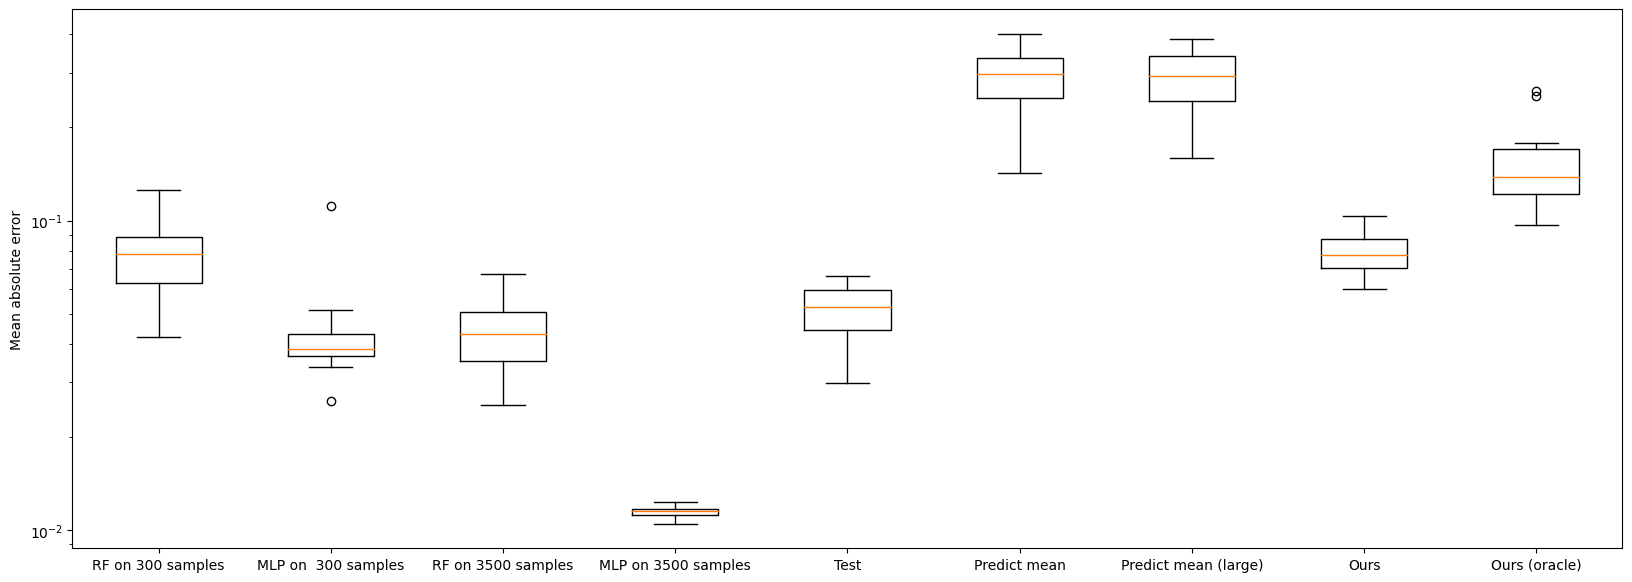

In [62]:
import matplotlib.pyplot as plt

#plt.boxplot([res_rf_X1, res_rf_X1_large, res_ours], labels=["RF on X1", "RF on X1 (large)", "Ours"])
# figsize=(10, 10)
fig, ax = plt.subplots(figsize=(20, 7))
plt.boxplot([res_rf_X1, res_mlp_X1, res_rf_X1_large, res_mlp_X1_large, res_test, predict_mean, predict_mean_large, res_ours, res_ours_oracle], labels=[f"RF on {train_size_small} samples", f"MLP on  {train_size_small} samples", f"RF on {train_size_large} samples", f"MLP on {train_size_large} samples", "Test", "Predict mean", "Predict mean (large)", "Ours", "Ours (oracle)"])
#plt.boxplot([res_rf_X1, res_mlp_X1, res_rf_X1_large, res_mlp_X1_large, res_test, predict_mean, predict_mean_large], labels=[f"RF on {train_size_small} samples", f"MLP on  {train_size_small} samples", f"RF on {train_size_large} samples", f"MLP on {train_size_large} samples", "Test", "Predict mean", "Predict mean (large)"])
plt.ylabel("Mean absolute error")
plt.yscale("log")
#plt.title(f"Comparison of the different methods: X1 contains {X1.shape[0]} samples, X2 contains {X2.shape[0]} samples.")
plt.show()

In [ ]:
# match indices of dataset1 and dataset2 on the first coordinate
distance = torch.cdist(dataset1[:, 0].reshape(-1, 1), dataset2[:, 0].reshape(-1, 1))
# replace the 2nd coordinate of dataset1 by the 2nd coordinate of dataset2
dataset1_copy = dataset1.clone()
dataset1_copy[:, 1] = torch.sum(dataset2[distance.argmin(dim=1)], dim=1)


print("-- Random Forest --")
print("Accuracy with dataset1", compute_accuracy_rf(dataset1_copy, y, 1000))
print("Accuracy with dataset2", compute_accuracy_rf(dataset2, y, 1000))


In [ ]:
print("-- TabPFN original --")
print("Accuracy with dataset1", compute_accuracy_tabpfn_original(dataset1, y, 1000))
#print("Accuracy with dataset2", compute_accuracy_tabpfn_original(dataset2, y, 1000))

In [ ]:
print("-- TabPFN --")
print("Without preprocessing")
print("Accuracy with dataset1", compute_accuracy_tabpfn(dataset1, y, 1000, preprocess=False))
print("Accuracy with dataset2", compute_accuracy_tabpfn(dataset2, y, 1000, preprocess=False))
print("With preprocessing")
print("Accuracy with dataset1", compute_accuracy_tabpfn(dataset1, y, 1000, preprocess=True))
print("Accuracy with dataset2", compute_accuracy_tabpfn(dataset2, y, 1000, preprocess=True))

In [ ]:
#train_attention(module, dataset1, dataset2, y, 1000, preprocess=True, lr=0.001, n_epochs=1000, train_tabpfn=False)
train_matching(dataset1, dataset2, y, 256, preprocess=True, lr=0.001, n_epochs=10)

# Real data

In [ ]:
device = "cuda:0"
model = TabPFNClassifier(device=device)

module = model.model[2]

## California

In [ ]:
# Try the same thing on the california housing dataset
from sklearn.datasets import fetch_california_housing
import pandas as pd

data = fetch_california_housing(as_frame=True)

In [ ]:
df_california = data["frame"]
# drop the target
df_california = df_california.drop("MedHouseVal", axis=1)
# drop income
df_california_without_income = df_california.drop("MedInc", axis=1)
# Drop more columns to make it harder
# df_california = df_california.drop("AveOccup", axis=1)
# df_california_without_income = df_california_without_income.drop("AveOccup", axis=1)
# only keep Latitude and Longitude
df_california = df_california[["MedInc", "Latitude", "Longitude"]]
df_california_without_income = df_california_without_income[["Latitude", "Longitude"]]
target = data["target"]

In [ ]:
df_california

In [ ]:
data = {'City': ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach', 'Oakland', 'Bakersfield', 'Anaheim', 'Santa Ana', 'Riverside', 'Stockton', 'Chula Vista', 'Irvine', 'Fremont', 'San Bernardino', 'Modesto', 'Fontana', 'Oxnard'], 
        'Average Household Income': ['$101,006', '$113,681', '$150,601', '$167,663', '$73,396', '$87,213', '$89,912', '$116,585', '$84,592', '$97,136', '$88,829', '$90,520', '$78,712', '$105,155', '$140,764', '$170,083', '$64,929', '$81,841', '$93,383', '$91,636']}

df_cities = pd.DataFrame(data)

In [ ]:
# Get lat and long for each city
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application (leo.grinsztajn@gmail.com)")
df_cities["location"] = df_cities["City"].apply(lambda x: geolocator.geocode(x))
df_cities["latitude"] = df_cities["location"].apply(lambda x: x.latitude)
df_cities["longitude"] = df_cities["location"].apply(lambda x: x.longitude)


### Baselines

In [ ]:
# Convert target to a classification problem
target_classif = (target > np.median(target)).astype(int)

# Convert df_california to a torch tensor
california_tensor = torch.tensor(df_california.values).float()
california_without_income_tensor = torch.tensor(df_california_without_income.values).float()
target_tensor = torch.tensor(target_classif.values).float()

# Suffle the data
from sklearn.utils import shuffle
california_tensor, california_without_income_tensor, target_tensor = shuffle(california_tensor, california_without_income_tensor, target_tensor, random_state=0)

In [ ]:
# Reshape
california_tensor = california_tensor.reshape(california_tensor.shape[0], 1, california_tensor.shape[1])
california_without_income_tensor = california_without_income_tensor.reshape(california_without_income_tensor.shape[0], 1, california_without_income_tensor.shape[1])
target_tensor = target_tensor.reshape(target.shape[0], 1)

In [ ]:
# Truncate the first dim to 5000
california_tensor = california_tensor[:5000]
california_without_income_tensor = california_without_income_tensor[:5000]
target_tensor = target_tensor[:5000]

print(np.unique(target_tensor, return_counts=True))
# print proportion of 1
p = np.unique(target_tensor, return_counts=True)[1][1] / np.unique(target_tensor, return_counts=True)[1].sum()
print(p)
print(1-p)


In [ ]:
print(california_tensor.shape)
print(california_without_income_tensor.shape)

In [ ]:
# Move to GPU
california_tensor = california_tensor.to(device)
california_without_income_tensor = california_without_income_tensor.to(device)
target_tensor = target_tensor.to(device)

In [ ]:
#model = TabPFNClassifier(N_ensemble_configurations=1, feature_shift_decoder=False)

#module = model.model[2]
# Pad with 0s until we have 100 features

n_samples, n_features = california_tensor.shape[0], california_tensor.shape[2]
model.fit(california_tensor[:1000].reshape(1000, n_features).cpu(), target_tensor[:1000].reshape(1000).cpu())
y_pred = model.predict(california_tensor[1000:].reshape(4000, n_features).cpu())
print("Accuracy with income")
print(accuracy_score(target_tensor[1000:].reshape(-1).cpu(), y_pred))

n_samples, n_features = california_without_income_tensor.shape[0], california_without_income_tensor.shape[2]
model.fit(california_without_income_tensor[:1000].reshape(1000, n_features).cpu(), target_tensor[:1000].reshape(1000).cpu())
y_pred = model.predict(california_without_income_tensor[1000:].reshape(4000, n_features).cpu())
print("Accuracy without income")
print(accuracy_score(target_tensor[1000:].reshape(-1).cpu(), y_pred))





In [ ]:
# Preprocess the data
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
#TODO why the difference with random forest?
#scaler = StandardScaler()
#california_tensor_processed = torch.tensor(scaler.fit_transform(california_tensor.reshape(-1, california_tensor.shape[-1])).reshape(california_tensor.shape))
#california_without_income_tensor_processed = torch.tensor(scaler.fit_transform(california_without_income_tensor.reshape(-1, california_without_income_tensor.shape[-1])).reshape(california_without_income_tensor.shape))
print(california_tensor.shape)
california_tensor_processed = preprocess_input(california_tensor, target_tensor, [], preprocess_transform='power')
california_without_income_tensor_processed = preprocess_input(california_without_income_tensor, target_tensor, [], preprocess_transform='power')
# Pad last dimension with 0 to 100
california_tensor_processed = torch.nn.functional.pad(california_tensor_processed, (0, 100-california_tensor.shape[2]))
california_without_income_tensor_processed = torch.nn.functional.pad(california_without_income_tensor_processed, (0, 100-california_without_income_tensor.shape[2]))
print(california_tensor_processed.shape)
# convert to float
california_tensor_processed = california_tensor_processed.float()
y_pred = torch.argmax(module((california_tensor_processed, target_tensor), single_eval_pos=1000, x_already_encoded=False), dim=-1).reshape(-1)
california_without_income_tensor_processed = california_without_income_tensor_processed.float()
y_pred2 = torch.argmax(module((california_without_income_tensor_processed, target_tensor), single_eval_pos=1000, x_already_encoded=False), dim=-1).reshape(-1)
# print shapes
print(y_pred.shape)
print(y_pred2.shape)

from sklearn.metrics import accuracy_score
print("Accuracy with income")
print(accuracy_score(target_tensor[-len(y_pred):].cpu(), y_pred.cpu()))
print("Accuracy without income")
print(accuracy_score(target_tensor[-len(y_pred2):].cpu(), y_pred2.cpu()))

In [ ]:
# Try with a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
X, y = california_tensor.reshape(california_tensor.shape[0], -1).cpu().numpy(), target_tensor.reshape(-1).cpu().numpy()
# The train part is the first 1000 samples
rf.fit(X[:1000], y[:1000])
y_pred = rf.predict(X[1000:])
print("Accuracy with income")
print(accuracy_score(y[1000:], y_pred))

# without income
rf = RandomForestClassifier()
X, y = california_without_income_tensor.reshape(california_without_income_tensor.shape[0], -1).cpu().numpy(), target_tensor.reshape(-1).cpu().numpy()
# The train part is the first 1000 samples
rf.fit(X[:1000], y[:1000])
y_pred = rf.predict(X[1000:])
print("Accuracy without income")
print(accuracy_score(y[1000:], y_pred))



### Supervised join

In [ ]:
df_cities

In [ ]:
#convert value like $101,006' to 101006
df_cities["Average Household Income"] = df_cities["Average Household Income"].apply(lambda x: int(x.replace("$", "").replace(",", "")))


In [ ]:
df_cities.head()

In [ ]:
# Convert df_cities to a torch tensor
cities_tensor = torch.tensor(df_cities[["Average Household Income", "latitude", "longitude"]].values).float()
# Reshape
cities_tensor = cities_tensor.reshape(cities_tensor.shape[0], 1, cities_tensor.shape[1])

# preporcess the data
#cities_tensor_processed = preprocess_input(cities_tensor, target_tensor, [], preprocess_transform='power')
#cities_tensor_processed = cities_tensor
# Use a standard scaler
scaler = StandardScaler()
cities_tensor_processed = torch.tensor(scaler.fit_transform(cities_tensor.reshape(-1, cities_tensor.shape[-1])).reshape(cities_tensor.shape))
# convert to float
cities_tensor_processed = cities_tensor_processed.float()

# Pad last dimension with 0 to 100
#TODO: think, do I need to do this or can I just put the vector in the attention?
cities_tensor_processed = torch.nn.functional.pad(cities_tensor_processed, (0, 100-cities_tensor.shape[2]))

In [ ]:
# move to GPU
cities_tensor_processed = cities_tensor_processed.to(device)

In [ ]:
# import multihead attention
from torch.nn import MultiheadAttention
n = 512
attention = MultiheadAttention(embed_dim=n, num_heads=1, dropout=0.0, device=device)
W_q = torch.rand(n, n).to(device)
W_k = torch.rand(n, n).to(device)
W_v = torch.rand(n, n).to(device)
W_q.requires_grad = True
W_k.requires_grad = True
W_v.requires_grad = True


In [ ]:
train_size = 1000
val_size = 2000
test_size = 2000

assert train_size + val_size + test_size == len(california_tensor_processed)

In [ ]:
# Suffle the "Average Household Income" column
cities_tensor_processed_random = cities_tensor_processed[torch.randperm(cities_tensor_processed.shape[0])]

In [ ]:
# optimize the attention matrix W_q, W_k, W_v
#TODO: check if we train on test
from torch import optim
optimizer = optim.Adam([W_q, W_k, W_v], lr=0.01)
for i in range(100):
    optimizer.zero_grad()
    input = model.model[2].encoder(california_without_income_tensor_processed)
    input2 = model.model[2].encoder(cities_tensor_processed)
    Q = torch.matmul(input, W_q)
    K = torch.matmul(input2, W_k)
    V = torch.matmul(input2, W_v)
    full_input = input + attention(Q, K, V)[0]
    y_pred = module((full_input, target_tensor), single_eval_pos=train_size, x_already_encoded=True).squeeze()
    loss = torch.nn.functional.cross_entropy(y_pred[:val_size], target_tensor[-len(y_pred):-len(y_pred) + val_size].squeeze().long())
    loss.backward()
    optimizer.step()
    print(loss)
    if i % 10 == 0:
        y_pred = torch.argmax(y_pred, dim=-1).reshape(-1)
        print(accuracy_score(target_tensor[-len(y_pred) + val_size:].cpu(), y_pred[val_size:].cpu()))

In [ ]:
#TODO: GPU and correct scoring of baselinees